# StarCMM+ Data Analysis #

Data analysis of StarCCM+ used for validation purposes. 

Test case parameters:

<b> Dimensions:<b/>
- Pipe Radius $R_t = 1$ mm 
- Pipe Length $L = 0.1$ m
    
<b> Boundary Conditions:<b/>
- No slip wall condition
- 1600 K at inlet, outlet, and walls (isothermal wall)
- Segregated Fluid Enthalpy

## Laminar Flow through pipe ## 

- 20 m/s inlet (velocity inlet stagnation inlet currently not working)
- Pressure Outlet

### Data Preprocessing ### 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def preprocess(xfile, yfile):
    x_raw = pd.read_csv('starccm_data/' + xfile)
    y_raw = pd.read_csv('starccm_data/' + yfile)

    x_raw.columns = ['x', 'var']
    y_raw.columns = ['y', 'var']
    
    data = pd.merge(x_raw, y_raw, on='var')
    data = data[['x','y','var']]
    data.sort_values(by=['x', 'y'], inplace=True)
    
    xx, yy = np.meshgrid(data.x.unique(), data.y.unique())
    zz = np.zeros(xx.shape)
    
    for i, x in enumerate(xx[0]):
        zz[:,i] = np.array(data[data.x==x].drop_duplicates(subset=['y'])['var'])
        
    return xx, yy, zz

In [3]:
xx, yy, zz = preprocess('direction_x.csv', 'direction_y.csv')

### Analysis ### 

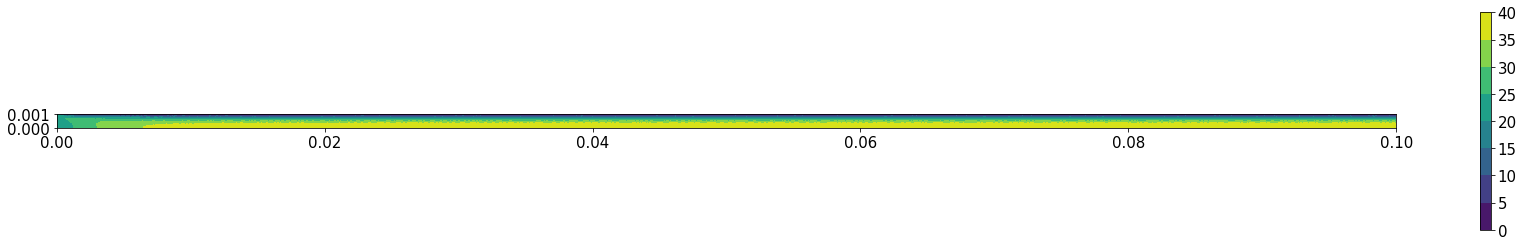

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(30, 4))
plt.contourf(xx, yy, zz)
plt.axis('scaled')
plt.colorbar()
plt.show()

### Comparison to Analytical Solution ###

Using the <b> Hagen-Poisseuille Law <b/>
    
$$ u_z(r) = -\frac{dp}{dz} \left( \frac{R^2-r^2}{4 \mu}\right) $$
    
Using:
    $$ \frac{dp}{dz} \sim \frac{\Delta p}{L} = 128 \frac{\mu L Q}{\pi d^4} $$ 
    
Where $L$ is the length of the pipe, $Q$ is the volumentric flow rate, and $d$ is the diameter of the pipe. Assuming incompressible flow, $Q = uA = u\pi r^2$.
    
At T = 1600 K, $\mu = 5.457 \times 10^{-5} \: \mathrm{kg \:m^{-1}s^{-1}}$.
    
Substituting gives $\Delta p / L = -8731.2 \: \mathrm{Pa \: m^{-1}}$
    
Sources:
    
https://kparker.bg-research.cc.ic.ac.uk/homepage/Mechanics%20of%20the%20Circulation/Chap_05/_Chapter_05.htm
    
https://www.engineeringtoolbox.com/dry-air-properties-d_973.html

In [5]:
R = 0.001 # m
L = 0.1 # m
dpdz = -8731.2 # Pa m-1
mu = 5.457e-5
u_analytical = -dpdz * (R**2 - yy[:,0]**2)/(4*mu)

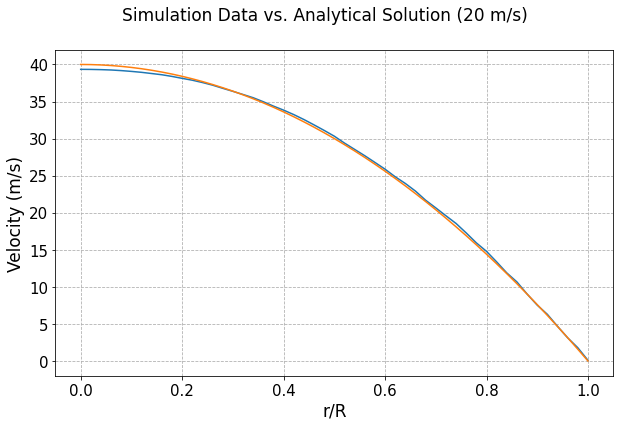

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(yy[:,0]/R, zz[:,-1])
ax.plot(yy[:,0]/R, u_analytical)
ax.grid(visible=True, which='major', linestyle='--')
ax.set_xlabel('r/R')
ax.set_ylabel('Velocity (m/s)')
fig.suptitle('Simulation Data vs. Analytical Solution (20 m/s)')
plt.show()

### Temperature Gradient ###

In [26]:
xx, yy, temp = preprocess('xgrid_temp.csv', 'ygrid_temp.csv')
xx, yy, rho = preprocess('xgrid_density.csv', 'ygrid_density.csv')
xx, yy, u = preprocess('xgrid_vel.csv', 'ygrid_vel.csv')
xx, yy, p = preprocess('xgrid_press.csv', 'ygrid_press.csv')

In [27]:
# Taking average along tube

x = xx[0,:]

t_bar = np.mean(temp, axis=0)
rho_bar = np.mean(rho, axis=0)
u_bar = np.mean(u, axis=0)
p_bar = np.mean(p, axis=0) + 101325

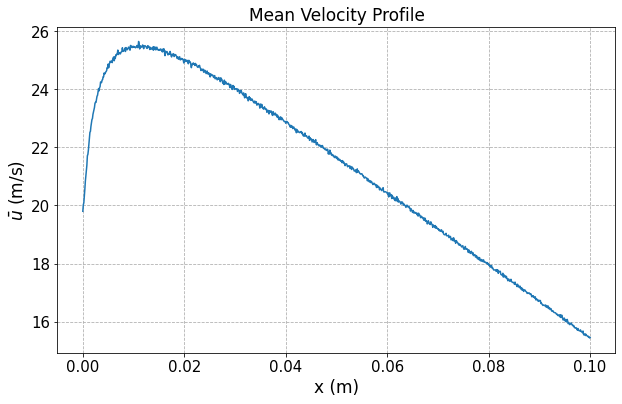

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x, u_bar)
ax.set_xlabel('x (m)')
ax.set_ylabel(r'$\bar{u}$ (m/s)')
ax.set_title('Mean Velocity Profile')
ax.grid(visible=True, which='major', linestyle='--')

In [36]:
x = x[200:] - x[200]
t_bar = t_bar[200:]
rho_bar = rho_bar[200:]
u_bar = u_bar[200:]
p_bar = p_bar[200:] 

By observation, taking points from 0.02 m onwards. 

In [37]:
c = np.sqrt(1.4*287*t_bar)

In [38]:
M = u_bar/c

In [76]:
from model import TemperatureGradientModel

In [77]:
t_bar[0], t_bar[-1]

(1516.1121850107231, 934.6516304764093)

In [78]:
analytical = TemperatureGradientModel(x[-1]-x[0], 0, 800, p_bar[0], M[0], t_bar[0], t_bar[-1])
analytical.calculate()

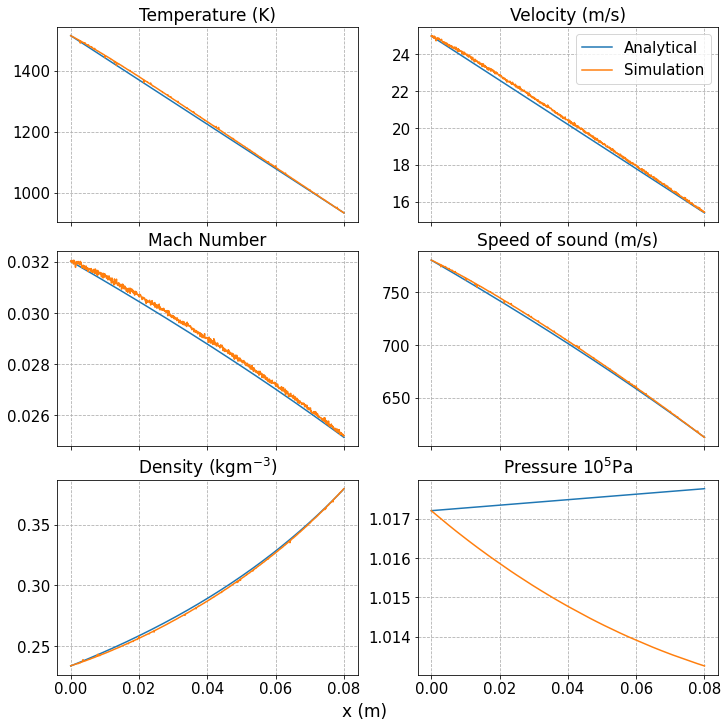

In [79]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize = (10, 10), constrained_layout=True, sharex=True)
ax[0][0].plot(analytical.x, analytical.T)
ax[0][1].plot(analytical.x, analytical.u)
ax[1][0].plot(analytical.x, analytical.M)
ax[1][1].plot(analytical.x, analytical.c)
ax[2][0].plot(analytical.x, analytical.rho)
ax[2][1].plot(analytical.x, analytical.p/100000)

ax[0][0].plot(x, t_bar)
ax[0][1].plot(x, u_bar)
ax[1][0].plot(x, M)
ax[1][1].plot(x, c)
ax[2][0].plot(x, rho_bar)
ax[2][1].plot(x, p_bar/100000)


ax[0][0].set_title('Temperature (K)')
ax[0][1].set_title('Velocity (m/s)')
ax[1][0].set_title('Mach Number')
ax[1][1].set_title('Speed of sound (m/s)')
ax[2][0].set_title(r'Density ($\mathrm{kgm^{-3}}$)')
ax[2][1].set_title(r'Pressure $10^{5} \mathrm{Pa}$')

ax[0][1].legend(['Analytical', 'Simulation'])

for axes in ax.flat:
    axes.grid(visible=True, which='major', linestyle='--')
fig.supxlabel('x (m)')
fig.savefig('mean_profile1.png')
fig.show()

### Incorporating Analytical Pressure Loss ### 

In [80]:
import sympy as sp

from scipy.integrate import quad
from scipy.io import loadmat

j = complex(0, 1)
e = np.e

class TemperatureGradientModel:
    gamma = 1.4
    Rg = 287
    Rt = 0.001
    def __init__(self, L, x1, n, p1, M1, T1, T2, temp_dist = 'lin', Z1 = -1, fl_c = 1, viscous_effects=False, losses=True):
        self.L = L
        self.x1 = x1
        self.p1 = p1
        self.x = np.linspace(x1, L, n)
        self.dx = self.x[1] - self.x[0]
        self.M1 = M1
        self.T1 = T1
        self.T2 = T2
        self.Z1 = Z1
        self.temp_dist = temp_dist
        self.fl_c = fl_c
        self.losses=losses
        
        if self.temp_dist == 'lin':
            self.T = self.T1 + (self.T2-self.T1)/self.L*(self.x-self.x1)

        elif self.temp_dist == 'sin':
            self.T = (self.T1-self.T2)/2*np.sin(5*np.pi/4*(self.x-self.x1)/self.L + np.pi/4)+(self.T1+self.T2)/2

        self.c1 = np.sqrt(self.gamma * self.Rg * self.T[0])
        self.u1 = self.M1 * self.c1
        self.rho1 = self.p1/(self.Rg*self.T[0])
        
        self.A = self.rho1*self.u1
        self.B = self.p1 + self.rho1*self.u1**2
        
        self.w = self.fl_c*2*np.pi*self.c1/self.L
        self.viscous_effects = viscous_effects
        
    def calculate(self):
        self.calculate_mean_properties()
        self.calculate_flow_properties()
        
    
    def _grad(self, q):
        dqdx = np.zeros(q.shape)
        dqdx[1:-1] = (q[2:]-q[:-2])/(2*self.dx)
        dqdx[0] = (q[1]-q[0])/self.dx
        dqdx[-1] = (q[-1]-q[-2])/self.dx
        return dqdx
        
        
    def calculate_mean_properties(self):
        self.c = np.sqrt(self.gamma * self.Rg * self.T)
        self.u = (self.B/self.A - np.sqrt((self.B/self.A)**2 - 4*self.Rg * self.T))/2
        self.dudx = self._grad(self.u)
        self.rho = self.A/self.u

        self.M = self.u/self.c
        self.alpha = 1/self.rho*self._grad(self.rho)
        
        def dynamic_viscosity(T):
            if (100 <= T <= 1000):
                return 1.716e-5*(T/273.15)**(3/2)*383.55/(T+110.4)
            elif(1000 < T <= 3000):
                return 2.653e-8*T+1.573e-5
            
        self.mu = np.array([dynamic_viscosity(t) for t in self.T])
            
        if self.losses:
            self.dpdx = -0.5*self.rho1*self.u1*self.dudx-128*self.mu*self.u*np.pi*self.Rt**2/(np.pi*(self.Rt*2)**4)
            self.p = np.zeros(self.T.shape)
            self.p[0] = self.p1
            # self.p = self.rho*self.Rg*self.T
            for i in range(1, len(self.p)):
                self.p[i] = self.p[i-1] + self.dx*self.dpdx[i-1]
        else:
            self.p = self.rho*self.Rg*self.T
        
        
        self.v = self.mu/self.rho
        self.Pr = 0.71
        self.Sh = self.Rt * (self.w/self.v)**0.5
        
        if self.viscous_effects:
            self.k0 = self.w/(self.c*(1+self.M))*(1+(1-j)/np.sqrt(2)/self.Sh*(1+(self.gamma-1)/(self.Pr**(1/2)))-j/(self.Sh**2)*(1+(self.gamma-1)/(self.Pr**(1/2))-self.gamma/2*(self.gamma-1)/self.Pr))
        else:
            self.k0 = self.w/self.c
        return
    
    
    def plot_mean_properties(self):
        return
        
        
    def _numerical_integration(self):
        
        def c_T(T):
            return np.sqrt(self.gamma*self.Rg*T)

        def u_T(T):
            return (self.B/self.A - np.sqrt((self.B/self.A)**2-4*self.Rg*T))/2

        def T_x(x):
            if self.temp_dist == 'lin':
                return self.T1+(self.T2-self.T1)*(x-self.x1)/self.L
            else:
                return (self.T1-self.T2)/2*np.sin(5*np.pi/4*(x-self.x1)/self.L + np.pi/4)+(self.T1+self.T2)/2
        
        def integrand_plus(x):
            return 1/(c_T(T_x(x)) + u_T(T_x(x)))

        def integrand_minus(x):
            return 1/(c_T(T_x(x)) - u_T(T_x(x)))
        
        def integral_plus(x):
            return quad(integrand_plus, self.x1, x)[0]

        def integral_minus(x):
            return quad(integrand_minus, self.x1, x)[0]
        
        self.integrals_plus = np.array([integral_plus(value) for value in self.x])
        self.integrals_minus = np.array([integral_minus(value) for value in self.x])
        
    
    def _get_intermediate_vals(self, rho, M, rho1, M1, gamma, w, c, alpha, integrals_plus, integrals_minus):
        self.P1_plus = (rho/rho1)**(1/4)*(1+M1)/(1+M)*(np.exp(gamma*M1-gamma/4*M1**2-(gamma**2-1)/3*M1**3))/(np.exp(gamma*M-gamma/4*M**2-(gamma**2-1)/3*M**3))*np.exp(-j*w*integrals_plus)
        self.P1_minus= (rho/rho1)**(1/4)*(1-M1)/(1-M)*(np.exp(gamma*M+gamma/4*M**2-(gamma**2-1)/3*M**3))/(np.exp(gamma*M1+gamma/4*M1**2-(gamma**2-1)/3*M1**3))*np.exp(j*w*integrals_minus)
        self.K1 = (j*self.k0-(1+2*(1+gamma)*M+(3*gamma-7)*M**2)*alpha/4)/(j*self.k0-alpha*M)
        self.K2 = (j*self.k0+(1-2*(1+gamma)*M+(3*gamma-7)*M**2)*alpha/4)/(j*self.k0-alpha*M)
        
        
    def _get_flow_properties(self, C1_plus, C1_minus, P1_plus, P1_minus, K1, K2, rho, c):
        self.p_hat = C1_plus*P1_plus + C1_minus*P1_minus
        self.u_hat = K1*C1_plus*P1_plus/(rho*c) - K2*C1_minus*P1_minus/(rho*c)
        self.Fp = self.p_hat/(rho[0]*c[0]*self.u_hat[0])
        self.Fu = self.u_hat/self.u_hat[0]
        
    
    def calculate_flow_properties(self):
        self._numerical_integration()
        self._get_intermediate_vals(self.rho, self.M, self.rho1, self.M1, self.gamma, self.w, self.c, self.alpha, self.integrals_plus, self.integrals_minus)
        
        # Initial conditions don't matter, plots later on are initialised
        # self.p0 = 100
        # self.u0 = self.p0/(self.rho[0]*self.c[0]*self.Z1)
        
        self.u0 = 1
        self.p0 = self.rho[0] * self.c[0] * self.Z1 * self.u0
        
        self.C1_plus = self.p0*(self.K2[0] + 1/self.Z1)/(self.K1[0] + self.K2[0])
        self.C1_minus = self.p0*(self.K1[0] - 1/self.Z1)/(self.K1[0] + self.K2[0])
        
        self._get_flow_properties(self.C1_plus, self.C1_minus, self.P1_plus, self.P1_minus, self.K1, self.K2, self.rho, self.c)
        
        
    def plot_flow_properties(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (14, 8))
        ax1.plot(self.x/self.L, abs(self.Fp))
        ax2.plot(self.x/self.L, abs(self.Fu))
        ax3.plot(self.x/self.L, np.angle(self.Fp)/np.pi)
        ax4.plot(self.x/self.L, np.angle(self.Fu)/np.pi)
        ax1.set_xlabel('x/l')
        ax2.set_xlabel('x/l')
        ax3.set_xlabel('x/l')
        ax4.set_xlabel('x/l')
        ax1.set_ylabel('|Fp|')
        ax2.set_ylabel('|Fu|')
        ax3.set_ylabel('<Fp/pi')
        ax4.set_ylabel('<Fu/pi')
        fig.show()
        
    
    def plot_mean_properties(self):
        # Need to plot temperature, velocity, mach number, speed of sound, density, pressure
        fig, ax = plt.subplots(ncols=2, nrows=3, figsize = (10, 10), constrained_layout=True, sharex=True)
        titles = ['Temperature', ]
        ax[0][0].plot(self.x, self.T)
        ax[0][1].plot(self.x, self.u)
        ax[1][0].plot(self.x, self.M)
        ax[1][1].plot(self.x, self.c)
        ax[2][0].plot(self.x, self.rho)
        ax[2][1].plot(self.x, self.p/100000)
        
        
        ax[0][0].set_title('Temperature (K)')
        ax[0][1].set_title('Velocity (m/s)')
        ax[1][0].set_title('Mach Number')
        ax[1][1].set_title('Speed of sound (m/s)')
        ax[2][0].set_title(r'Density ($\mathrm{kgm^{-3}}$)')
        ax[2][1].set_title(r'Pressure $10^{5} \mathrm{Pa}$')
        
        for axes in ax.flat:
            axes.grid(visible=True, which='major', linestyle='--')
        fig.supxlabel('x/L')

In [81]:
analytical = TemperatureGradientModel(x[-1]-x[0], 0, 800, p_bar[0], M[0], t_bar[0], t_bar[-1], temp_dist='lin')
analytical.calculate()

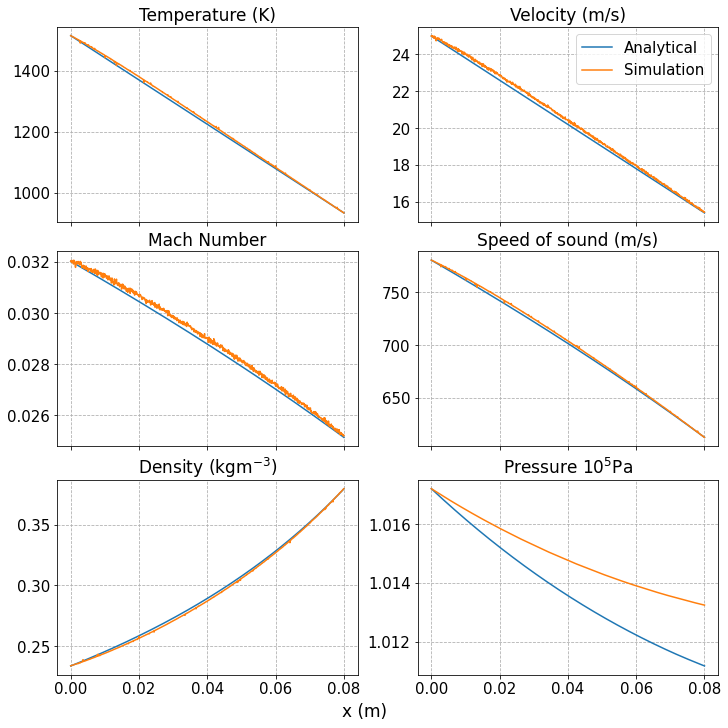

In [82]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize = (10, 10), constrained_layout=True, sharex=True)
ax[0][0].plot(analytical.x, analytical.T)
ax[0][1].plot(analytical.x, analytical.u)
ax[1][0].plot(analytical.x, analytical.M)
ax[1][1].plot(analytical.x, analytical.c)
ax[2][0].plot(analytical.x, analytical.rho)
ax[2][1].plot(analytical.x, analytical.p/100000)

ax[0][0].plot(x, t_bar)
ax[0][1].plot(x, u_bar)
ax[1][0].plot(x, M)
ax[1][1].plot(x, c)
ax[2][0].plot(x, rho_bar)
ax[2][1].plot(x, p_bar/100000)


ax[0][0].set_title('Temperature (K)')
ax[0][1].set_title('Velocity (m/s)')
ax[1][0].set_title('Mach Number')
ax[1][1].set_title('Speed of sound (m/s)')
ax[2][0].set_title(r'Density ($\mathrm{kgm^{-3}}$)')
ax[2][1].set_title(r'Pressure $10^{5} \mathrm{Pa}$')

ax[0][1].legend(['Analytical', 'Simulation'])

for axes in ax.flat:
    axes.grid(visible=True, which='major', linestyle='--')
fig.supxlabel('x (m)')
fig.savefig('mean_profile2.png')
fig.show()